In [1]:
import warnings;
warnings.filterwarnings('ignore');
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Importing the data
data=pd.read_csv('creditcard.csv')

In [3]:
#Scaling Time and Amount as all the other fetaures are scaled already
from sklearn.preprocessing import RobustScaler

scaled_Amount=RobustScaler().fit_transform(data.Amount.values.reshape(-1,1))
scaled_Time=RobustScaler().fit_transform(data.Amount.values.reshape(-1,1))

In [4]:
data.drop(['Amount','Time'],axis=1,inplace=True)
data.insert(0,'Scaled Amount',scaled_Amount)
data.insert(1,'Scaled Time',scaled_Time)

In [5]:
X=data.drop('Class',axis=1)
Y=data.Class

In [6]:
#Splitting my Original Data set in Train and Test samples
#We will not be using these training samples as these are very unbalanced,we will be implementing under sampling and oversampling
#However, We will be using Test samples  created here to test the data set once it has been trained using under sampling or overampling techniques.
from sklearn.model_selection import StratifiedShuffleSplit

for train_index_number,test_index_number in StratifiedShuffleSplit().split(X,Y):
    original_x_train,original_x_test=X.iloc[train_index_number],X.iloc[test_index_number]
    original_y_train,original_y_test=Y.iloc[train_index_number],Y.iloc[test_index_number]

<h1>Over Sampling</h1>

In [7]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import  cross_val_score
from sklearn.model_selection import  GridSearchCV

In [8]:
smote=SMOTE(sampling_strategy='minority')
OverSampled_X_train,Oversampled_Y_train=smote.fit_resample(original_x_train,original_y_train)

In [9]:
OverSampled_X_train=pd.DataFrame(OverSampled_X_train,columns=original_x_train.columns)
Oversampled_Y_train=pd.Series(Oversampled_Y_train)

In [10]:
OverSampled_X_train.insert(loc=0,column='Class',value=Oversampled_Y_train)
OverSampled_X_train=OverSampled_X_train.sample(frac=1)

In [11]:
Oversampled_Y_train=OverSampled_X_train.Class
OverSampled_X_train=OverSampled_X_train.drop('Class',axis=1)

In [12]:
OD_correlation_matrix=OverSampled_X_train.corr()
OD_highly_correlated=set()
for i in range(len(OD_correlation_matrix.columns)):
    for j in range(i):
        if OD_correlation_matrix.iloc[i,j]>0.8 or OD_correlation_matrix.iloc[i,j]<-0.8:
            OD_highly_correlated.add(OD_correlation_matrix.columns[i])
        

In [13]:
OverSampled_X_train.drop(OD_highly_correlated,axis=1,inplace=True)

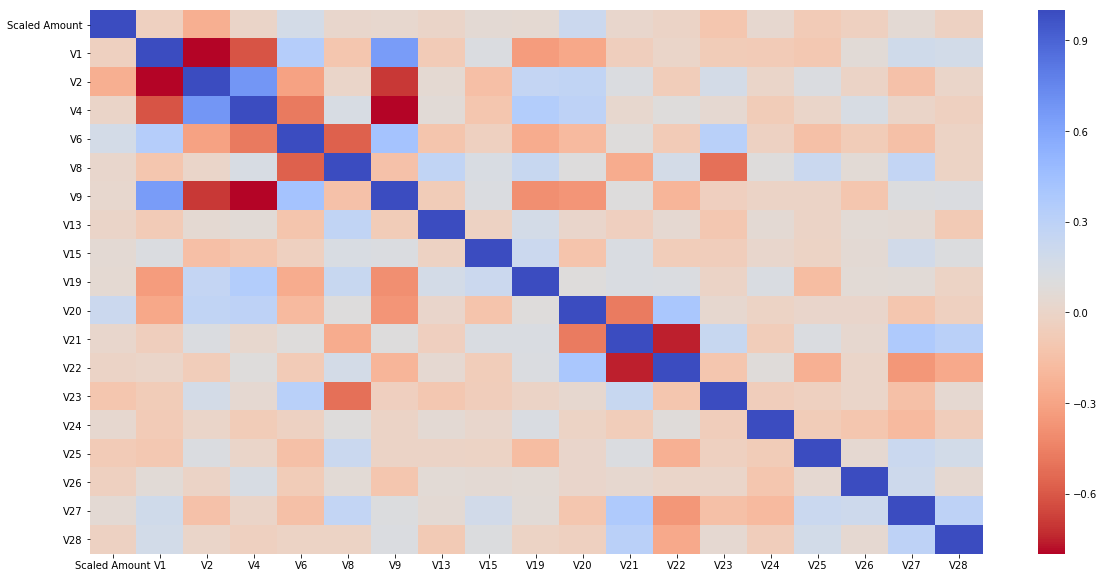

In [14]:
plt.figure(figsize=[20,10])
sb.heatmap(OverSampled_X_train.corr(),cmap='coolwarm_r')

In [15]:
def Outlierremovel(coloumn_name):
    OD_q25=np.percentile(OverSampled_X_train[coloumn_name],25)
    OD_q75=np.percentile(OverSampled_X_train[coloumn_name],75)
    OD_IQR=OD_q75-OD_q25
    OD_cut_off=OD_IQR*1.5
    OD_upper=OD_q75+OD_cut_off
    OD_lower=OD_q25-OD_cut_off
    index_values=OverSampled_X_train[(OverSampled_X_train[coloumn_name]>OD_upper)|(OverSampled_X_train[coloumn_name]<OD_lower)].index
    OverSampled_X_train.drop(index_values,inplace=True)
    Oversampled_Y_train.drop(index_values,inplace=True)
    
    

In [16]:
for coloumn in OverSampled_X_train.columns:
    Outlierremovel(coloumn)

In [17]:
original_x_test=original_x_test[OverSampled_X_train.columns]

In [18]:
from sklearn.decomposition import PCA
classif=PCA(n_components=2)
res_PCA=classif.fit_transform(OverSampled_X_train)

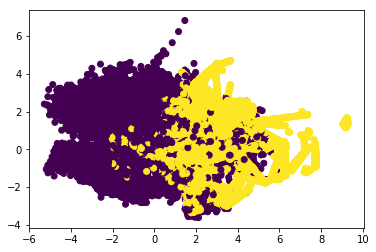

In [19]:
plt.scatter(x=res_PCA[:,0],y=res_PCA[:,1],c=(Oversampled_Y_train==1))

In [20]:
from sklearn.cluster import KMeans

cluster=KMeans(n_clusters=2)
cluster.fit(OverSampled_X_train)
res=cluster.predict(original_x_test)

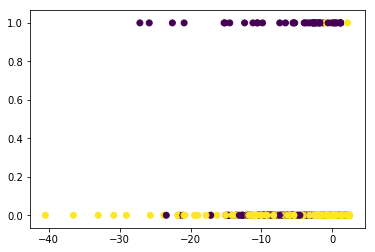

In [21]:
plt.scatter(original_x_test.V1,original_y_test,c=res)

In [22]:
OR_Classifiers=[LogisticRegression(),KNeighborsClassifier(),RandomForestClassifier()]

In [23]:
for classifier in OR_Classifiers:
    classifier.fit(OverSampled_X_train,Oversampled_Y_train)
    OD_CV_score=cross_val_score(classifier,OverSampled_X_train,Oversampled_Y_train,cv=5)
    print(f'The Cross Validation training Score for {classifier.__class__.__name__} with Default  Parameter is {OD_CV_score.mean()*100}%')

The Cross Validation training Score for LogisticRegression with Default  Parameter is 90.94111510161751%
The Cross Validation training Score for KNeighborsClassifier with Default  Parameter is 99.83202255660615%
The Cross Validation training Score for RandomForestClassifier with Default  Parameter is 99.98280541860241%


In [24]:
OD_log_reg_param={'penalty':['l1','l2'],'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
OD_K_neigber_param={"n_neighbors": [2,3,4,5], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
OD_random_forest_param={'n_estimators':[60,70,80,90,100,110,120,130,140,150,160,170],'criterion':['gini','entropy'],'max_features':[3,4,5,6,'auto']}

In [25]:
#OD_LOG_Reg=GridSearchCV(LogisticRegression(),OD_log_reg_param)
#OD_LOG_Reg.fit(OverSampled_X_train,Oversampled_Y_train)
#OD_Log_best_estimator=OD_LOG_Reg.best_estimator_    

In [26]:
#Computationally_too_expensive_to_run
#OD_RFC_Reg=GridSearchCV(RandomForestClassifier(),OD_random_forest_param)
#OD_RFC_Reg.fit(OverSampled_X_train,Oversampled_Y_train)
#OD_RFC_best_estimator=OD_LOG_Reg.best_estimator_

In [27]:
#Computationally_too_expensive_to_run
#OD_KNC_Reg=GridSearchCV(KNeighborsClassifier(),OD_K_neigber_param)
#OD_KNC_Reg.fit(OverSampled_X_train,Oversampled_Y_train)
#OD_KNC_best_estimator=OD_LOG_Reg.best_estimator_

In [28]:
from sklearn.model_selection import learning_curve

In [29]:
def plotlearningcurve(estim,train_set,test_set):
    train_size_OS,train_score,test_score=learning_curve(estim,train_set,test_set)
    train_score_mean=np.mean(train_score)
    train_score_std=np.std(train_score)
    test_score_mean=np.mean(test_score)
    test_score_std=np.std(test_score)
    plt.figure(figsize=[10,5])
    plt.xlabel('Training Example')
    plt.ylabel('Score')
    estimator_type=estim.__class__.__name__
    plt.title(estimator_type)
    plt.fill_between(train_size_OS,train_score_mean-train_score_std,train_score_mean+train_score_std,alpha=0.1)
    plt.fill_between(train_size_OS,test_score_mean-test_score_std,test_score_mean+test_score_std,alpha=0.1)
    plt.plot(train_size_OS,train_score,alpha=1,label='Training Score')
    plt.plot(train_size_OS,test_score,alpha=1,label='Testing Score')
    plt.grid()
    plt.legend()

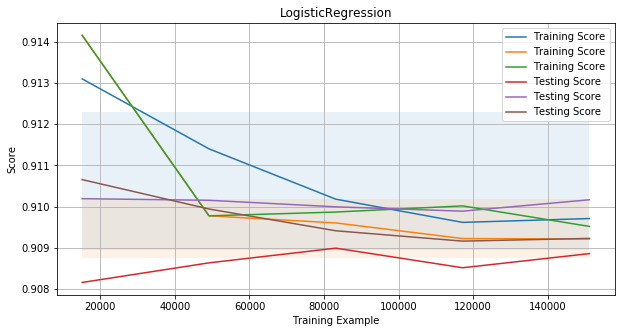

In [30]:
plotlearningcurve(LogisticRegression(),OverSampled_X_train,Oversampled_Y_train)

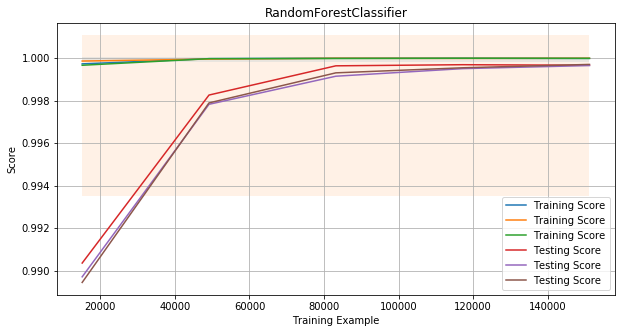

In [31]:
plotlearningcurve(RandomForestClassifier(),OverSampled_X_train,Oversampled_Y_train)

In [32]:
from sklearn.metrics import f1_score,confusion_matrix,precision_recall_curve,average_precision_score
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.model_selection import cross_val_predict

In [33]:
lg_reg_predict=cross_val_predict(LogisticRegression(),original_x_test,original_y_test)
RFC_true_score=cross_val_predict(RandomForestClassifier(),original_x_test,original_y_test)
KNC_true_score=cross_val_predict(KNeighborsClassifier(),original_x_test,original_y_test)

In [34]:
fpr,tpr,threshold=roc_curve(y_true=original_y_test,y_score=lg_reg_predict)

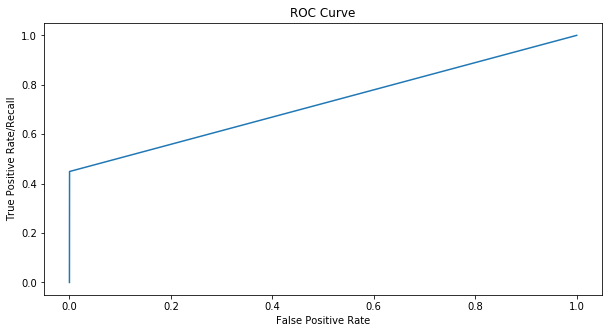

In [35]:
plt.figure(figsize=[10,5])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate/Recall')
plt.plot(fpr,tpr,alpha=2)

In [36]:
roc_auc_score(y_true=original_y_test,y_score=lg_reg_predict)

0.724384281005593

In [37]:
#y_pred=OD_Log_best_estimator.predict(original_x_test)

In [38]:
#confusion_matrix(original_y_test,y_pred)

In [39]:
f1_score(original_y_test,lg_reg_predict)

0.5714285714285714

In [40]:
average_precision_score(original_y_test,lg_reg_predict)

0.35371767972162504

In [43]:
precison,recall,threshold=precision_recall_curve(original_y_test,lg_reg_predict)

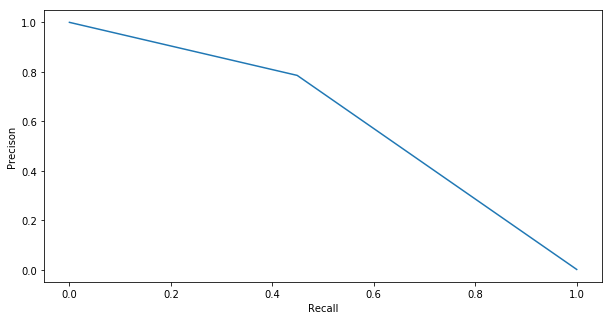

In [42]:
plt.figure(figsize=[10,5])
plt.xlabel('Recall')
plt.ylabel('Precison')
plt.plot(recall,precison,alpha=2)